In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def getDataLoaders(trainData, testData, batch_size):
    trainLoader = torch.utils.data.DataLoader(dataset=trainData,
                                              batch_size=batch_size,
                                              shuffle=True)
    testLoader = torch.utils.data.DataLoader(dataset=testData,
                                             batch_size=batch_size,
                                             shuffle=False)
    return trainLoader, testLoader

def getmnistDataLoaders(path, batch_size):
    trainData = datasets.MNIST(root=path,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
    testData = datasets.MNIST(root=path,
                              train=False,
                              transform=transforms.ToTensor())

    return getDataLoaders(trainData, testData, batch_size)


batch_size = 256

trainLoader, testLoader = getmnistDataLoaders("../data", batch_size)

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(28*28, 400)
        self.fμ = nn.Linear(400, 20)
        self.flogσ = nn.Linear(400, 20)

    def forward(self, x):
        h = F.relu(self.fc(x))
        return self.fμ(h), self.flogσ(h)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.LogSigmoid()
        )
    def forward(self, z):
        return self.f(z)

def reparameterize(μ, logσ):
    σ = torch.exp(logσ)
    ϵ = torch.randn_like(σ)
    return μ + σ * ϵ

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        μ, logσ = self.encoder(x)
        z = reparameterize(μ, logσ)
        logx̂ = self.decoder(z)
        ## loss
        term1 = F.binary_cross_entropy_with_logits(logx̂, x, reduction='sum')
        term2 = -0.5 * torch.sum(1 + 2*logσ - torch.pow(μ, 2) - torch.exp(2*logσ))
        return (term1 + term2) / x.size(0)

In [24]:
m = VAE().to(device)
optimizer = torch.optim.Adam(m.parameters())

In [30]:
iterations = len(trainLoader.dataset) // batch_size

In [31]:
epochs = 7
for epoch in range(epochs):
    epochLoss = 0.0
    for x, _ in trainLoader:
        x = x.reshape(-1, 784).to(device)
        loss = m(x)
        epochLoss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: {}  Loss: {}".format(epoch, epochLoss / iterations))

Epoch: 0  Loss: 162.2286123292059
Epoch: 1  Loss: 151.4620614337106
Epoch: 2  Loss: 146.29531658205212
Epoch: 3  Loss: 143.47079383002387
Epoch: 4  Loss: 141.84766994378506
Epoch: 5  Loss: 140.71226710132044
Epoch: 6  Loss: 139.88690778944226


## Visualization

In [36]:
def drawsamples(decoder, n):
    with torch.no_grad():
        z = torch.randn(n, 20).to(device)
        x = torch.exp(decoder(z))
        return x.reshape(n, 28, 28)

In [37]:
x = drawsamples(m.decoder, 5)
img = torch.cat(torch.unbind(x, dim=0)).cpu().numpy()

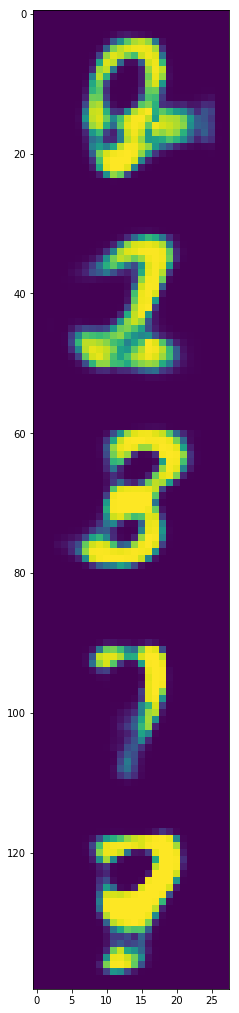

In [38]:
plt.figure(figsize=(4, 18))
plt.imshow(img)
#plt.savefig("../images/vae-1.png", bbox_inches='tight')